In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import time

import lightgbm

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

from matplotlib.pyplot import figure

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge

%matplotlib inline

In [2]:
rep_cols = {'ID':'ID', 
 '板温':'board_t', 
 '现场温度':'env_t', 
 '光照强度':'light_strength', 
 '转换效率':'efficiency', 
 '转换效率A':'efficiency_A', 
 '转换效率B':'efficiency_B', 
 '转换效率C':'efficiency_C', 
 '电压A':'V_A',
 '电压B':'V_B', 
 '电压C':'V_C', 
 '电流A':'I_A', 
 '电流B':'I_B', 
 '电流C':'I_C', 
 '功率A':'P_A', 
 '功率B':'P_B', 
 '功率C':'P_C', 
 '平均功率':'P_avg', 
 '风速':'wind_speed',
 '风向':'wind_direction', 
 '发电量':'y'
}

In [3]:
def my_val(preds, train_data):
    label = train_data.get_label()
    return 'score', 1/(1+np.sqrt(mean_squared_error(preds, label))), True
def my_obj(preds, train_data):
    labels = train_deata.get_label()

In [4]:
train = pd.read_csv('../data/public_raw.train.csv')
test = pd.read_csv('../data/public_raw.test.csv')

train_len = train.shape[0]

train['is_train']=1
test['is_train']=0

df = pd.concat([train, test],sort=False)

In [5]:
df.rename(index=str, columns=rep_cols, inplace=True)

df.sort_values(by=['ID'],ascending=True, inplace=True)

df.reset_index(drop=True, inplace=True)

In [6]:
#异常值处理
correct_dict = {
    'V_A':(480,60000),
    'V_B':(500,60000),
    'V_C':(500,60000),
}
# cols = [c for c in df.columns.tolist() if c!='y' and c!='ID']
# for c in correct_dict.keys():
#     df[c+'_is_out_of_upper'] = (df[c]>correct_dict[c][1]).astype(np.int32)
#     df[c+'_is_out_of_lower'] = (df[c]<correct_dict[c][0]).astype(np.int32)

In [7]:
df['to_correct'] = 0

In [8]:
# #电压值不包含0的版本
# for c in correct_dict.keys():
# #     condition = (df[c]>correct_dict[c][1]) | ((df[c]<correct_dict[c][0]) & (df[c]>0))

#     df[c+'_filtered'] = df[c]
#     df[c+'_filtered'][(df[c]>correct_dict[c][1]) | ((df[c]<correct_dict[c][0]) & (df[c]>0))] = np.nan 


In [9]:
#电压值包含0的版本
for c in correct_dict.keys():
#     condition = (df[c]>correct_dict[c][1]) | ((df[c]<correct_dict[c][0]) & (df[c]>0))

    df[c+'_filtered'] = df[c]
    df[c+'_filtered'][(df[c]>correct_dict[c][1]) | (df[c]<correct_dict[c][0]) ] = np.nan 
    df['to_correct'][(df[c]>correct_dict[c][1]) | ((df[c]<correct_dict[c][0]) & (df[c]>0))] = 1

C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [10]:
df[df['I_A']==0].shape

(114, 26)

In [11]:
#前二后二
next_one = []
prev_one = []
next_id = []
prev_id = []

second_next_one = []
second_prev_one = []

df_len = df.shape[0]

i_y =df.columns.get_loc("y")

def get_prev_nn_index(cur_i):
    prev_i = cur_i-1
    while(prev_i>=0 and pd.isnull(df.iat[prev_i,i_y])):
        prev_i-=1
    return prev_i

def get_next_nn_index(cur_i):
    prev_i = cur_i+1
    while(prev_i<df_len and pd.isnull(df.iat[prev_i,i_y])):
        prev_i+=1
    return prev_i

for i in range(df_len):
    f_pre_i=get_prev_nn_index(i)
    if(f_pre_i)<0:
        prev_one.append(np.nan)
        prev_id.append(0)
    else:
        prev_one.append(df.iat[f_pre_i,i_y])
        prev_id.append(f_pre_i)
        
    s_pre_i=get_prev_nn_index(f_pre_i)
    if (s_pre_i)<0:
        second_prev_one.append(np.nan)
    else:
        second_prev_one.append(df.iat[s_pre_i,i_y])
    
    f_next_i=get_next_nn_index(i)
    if(f_next_i<df_len):
        next_one.append(df.iat[f_next_i,i_y])
        next_id.append(f_next_i)
    else:
        next_one.append(np.nan)
        next_id.append(df_len)
    
    s_next_i=get_next_nn_index(f_next_i)
    if(s_next_i<df_len):
        second_next_one.append(df.iat[s_next_i,i_y])
    else:
        second_next_one.append(np.nan)

In [12]:
df['next_value'] = next_one
df['prev_value'] = prev_one
df['avg_value'] = np.nanmean([df['next_value'], df['prev_value']],axis=0)
df['next_ID'] = next_id
df['prev_ID'] = prev_id
# df['interpolation_ID'] = df['prev_value']+(df['ID']-df['prev_ID'])/(df['next_ID']-df['prev_ID'])*(df['next_value']-df['prev_value'])
# df['interpolation_ls'] = df['prev_value']+(df['light_strength']-df['prev_ls'])/(1+df['next_ls']-df['prev_ls'])*(df['next_value']-df['prev_value'])

df['second_prev_value'] = second_prev_one
df['second_next_value'] = second_next_one
# df['avg_value_four'] = np.nanmean([df['second_next_value'],df['next_value'], df['prev_value'],df['second_prev_value']],axis=0)


# df['rolling_seven'] = df['y'].rolling(7,center=True,min_periods=0).apply(lambda x: np.nanmean(x[[0,1,2,4,5,6]]))
# rolling_mask_two = [-i for i in range(1)]+[i for i in range(1)]
rolling_mask_two = [-i for i in range(1,2)]+[i for i in range(1,2)]
rolling_mask_four = [-i for i in range(1,3)]+[i for i in range(1,3)]
rolling_mask_six = [-i for i in range(1,4)]+[i for i in range(1,4)]
rolling_mask_eight = [-i for i in range(1,5)]+[i for i in range(1,5)]
# df['rolling_four_y'] = np.nanmean([df['y'].shift(i) for i in rolling_mask_four],axis=0)
df['rolling_six_y'] = np.nanmean([df['y'].shift(i) for i in rolling_mask_six],axis=0)
# df['rolling_eight_y'] = np.nanmean([df['y'].shift(i) for i in rolling_mask_eight],axis=0)
# df['rolling_eight_VA'] = np.nanmean([df['V_A'].shift(i) for i in rolling_mask_eight],axis=0)
# df['rolling_eight_VB'] = np.nanmean([df['V_B'].shift(i) for i in rolling_mask_eight],axis=0)
# df['rolling_eight_VC'] = np.nanmean([df['V_C'].shift(i) for i in rolling_mask_eight],axis=0)
df['rolling_six_VA'] = np.nanmean([df['V_A_filtered'].shift(i) for i in rolling_mask_six],axis=0)
df['rolling_six_VB'] = np.nanmean([df['V_B_filtered'].shift(i) for i in rolling_mask_six],axis=0)
df['rolling_six_VC'] = np.nanmean([df['V_C_filtered'].shift(i) for i in rolling_mask_six],axis=0)

C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice


In [13]:
df['VA_corrected'] = df['V_A']
df.loc[df['V_A_filtered'].isnull(),'VA_corrected'] = df['rolling_six_VA']
# df['VA_corrected'][df['V_A_filtered']==np.nan] = df['rolling_six_VA'] 
df['VB_corrected'] = df['V_B']
df.loc[df['V_B_filtered'].isnull(),'VB_corrected'] = df['rolling_six_VB']
df['VC_corrected'] = df['V_C']
df.loc[df['V_C_filtered'].isnull(),'VC_corrected'] = df['rolling_six_VC']

In [49]:
# df.sort_values(by='P_avg',ascending = False, inplace = False)[['ID','I_A','V_A','V_B','V_C','V_A_filtered','V_B_filtered','V_C_filtered','to_correct','rolling_six_VA','rolling_six_VB','rolling_six_VC','VA_corrected','VB_corrected','VC_corrected','PA_corrected','P_A']].head(60)
df.sort_values(by='P_avg',ascending = False, inplace = False)[['ID','board_t','light_strength','I_A','V_A','V_B','V_C','y']].head(60)

,ID,board_t,light_strength,I_A,V_A,V_B,V_C,y
5565,6016,5.68,564,7.96,667,65505,23,NaN
2071,2271,0.23,19,7.22,114,65353,14,NaN
1067,1175,2.53,233,7.07,553,65406,27,NaN
1722,1894,0.24,30,7.10,74,65350,22,0.780917
1950,2137,3.08,305,6.95,563,65428,30,NaN
2036,2223,1.23,131,7.06,297,65446,18,NaN
1065,1173,-5.83,233,7.04,65408,22,250,7.753474
14,22,-10.77,100,7.19,65382,7,107,5.440741
1178,1286,0.44,100,7.18,310,307,65438,4.694385
1373,1519,0.25,9,7.04,77,65387,14,0.839478


In [18]:
df[(df['ID']<600)&(df['ID']>585)][['ID','I_A','V_A','V_B','V_C','V_A_filtered','V_B_filtered','V_C_filtered','rolling_six_VA','rolling_six_VB','rolling_six_VC','to_correct']]

,ID,I_A,V_A,V_B,V_C,V_A_filtered,V_B_filtered,V_C_filtered,rolling_six_VA,rolling_six_VB,rolling_six_VC,to_correct
522,586,0.27,673,672,670,673.0,672.0,670.0,675.333333,675.000000,674.833333,0
523,587,0.28,677,674,682,677.0,674.0,682.0,677.166667,676.000000,673.500000,0
524,588,0.29,672,682,675,672.0,682.0,675.0,679.000000,675.000000,674.200000,0
525,589,0.31,675,681,678,675.0,681.0,678.0,677.750000,677.250000,676.250000,0
526,590,0.32,689,681,678,689.0,681.0,678.0,674.666667,679.000000,678.333333,0
527,591,6.68,36,65402,0,NaN,NaN,NaN,678.666667,681.333333,677.000000,1
528,592,1.56,36,65402,0,NaN,NaN,NaN,682.000000,681.000000,678.000000,1
529,593,6.68,37,65403,3,NaN,NaN,NaN,687.000000,682.000000,677.500000,1
530,594,1.56,37,65403,3,NaN,NaN,NaN,683.500000,683.000000,679.500000,1
531,595,6.77,37,39,65406,NaN,NaN,NaN,683.000000,680.000000,681.000000,1


In [19]:
df.sort_values(by='P_avg',ascending = False, inplace = False)[['ID','I_A','V_A','V_B','V_C','V_A_filtered','V_B_filtered','V_C_filtered','rolling_six_VA','rolling_six_VB','rolling_six_VC']].head(60)

,ID,I_A,V_A,V_B,V_C,V_A_filtered,V_B_filtered,V_C_filtered,rolling_six_VA,rolling_six_VB,rolling_six_VC
5565,6016,7.96,667,65505,23,667.0,NaN,NaN,670.000000,665.666667,664.000000
2071,2271,7.22,114,65353,14,NaN,NaN,NaN,728.166667,721.333333,727.500000
1067,1175,7.07,553,65406,27,553.0,NaN,NaN,706.800000,704.750000,705.500000
1722,1894,7.10,74,65350,22,NaN,NaN,NaN,724.833333,711.333333,718.333333
1950,2137,6.95,563,65428,30,563.0,NaN,NaN,697.833333,695.500000,695.500000
2036,2223,7.06,297,65446,18,NaN,NaN,NaN,708.333333,706.500000,704.666667
1065,1173,7.04,65408,22,250,NaN,NaN,NaN,681.666667,703.750000,706.750000
14,22,7.19,65382,7,107,NaN,NaN,NaN,722.666667,721.333333,720.833333
1178,1286,7.18,310,307,65438,NaN,NaN,NaN,716.000000,716.666667,714.666667
1373,1519,7.04,77,65387,14,NaN,NaN,NaN,712.000000,712.833333,708.166667


In [18]:
df['P_avg_corrected'] = df['P_avg']

df.loc[df['to_correct']==1 , ['P_avg_corrected']]=1/3*df['I_A']*(df['VA_corrected']+df['VB_corrected']+df['VC_corrected'])

In [15]:
df['PA_corrected'] = df['P_A']

df.loc[df['V_A_filtered'].isnull(),'PA_corrected'] = df['I_A']*df['VA_corrected']

In [11]:
# condition = (df['V_A'] > df['V_A'].quantile(0.995)) | ((df['V_A'] < df['V_A'].quantile(0.01)) & (df['V_A'] > 0)) | (df['V_B'] > df['V_B'].quantile(0.995)) | ((df['V_B'] < df['V_B'].quantile(0.01)) & (df['V_B'] > 0))| (df['V_C'] > df['V_C'].quantile(0.995)) | ((df['V_C'] < df['V_C'].quantile(0.01)) & (df['V_C'] > 0))

In [12]:
# CORRECTION!!!
#df.loc[condition , ['P_avg_corrected']]=1/3*df['I_A']*(df['V_A'].median()+df['V_B'].median()+df['V_C'].median())

In [13]:
# df.loc[df['V_B'] > df['V_B'].quantile(0.995), ['P_avg_corrected']]=1/3*df['I_A']*(df['V_B'].median()+df['V_A']+df['V_C'])

In [14]:
# df.loc[df['V_C'] > df['V_C'].quantile(0.995), ['P_avg_corrected']]=1/3*df['I_A']*(df['V_C'].median()+df['V_B']+df['V_A'])

In [22]:
df['P_avg'].describe()

count     17409.000000
mean       3126.824780
std        7844.852816
min           0.000000
25%        1222.100000
50%        2753.430000
75%        4272.710000
max      202906.540000
Name: P_avg, dtype: float64

In [23]:
df['P_avg_corrected'].describe()

count    17409.000000
mean      2737.761846
std       1642.701665
min          0.000000
25%       1222.100000
50%       2753.840000
75%       4272.650000
max       5918.580000
Name: P_avg_corrected, dtype: float64

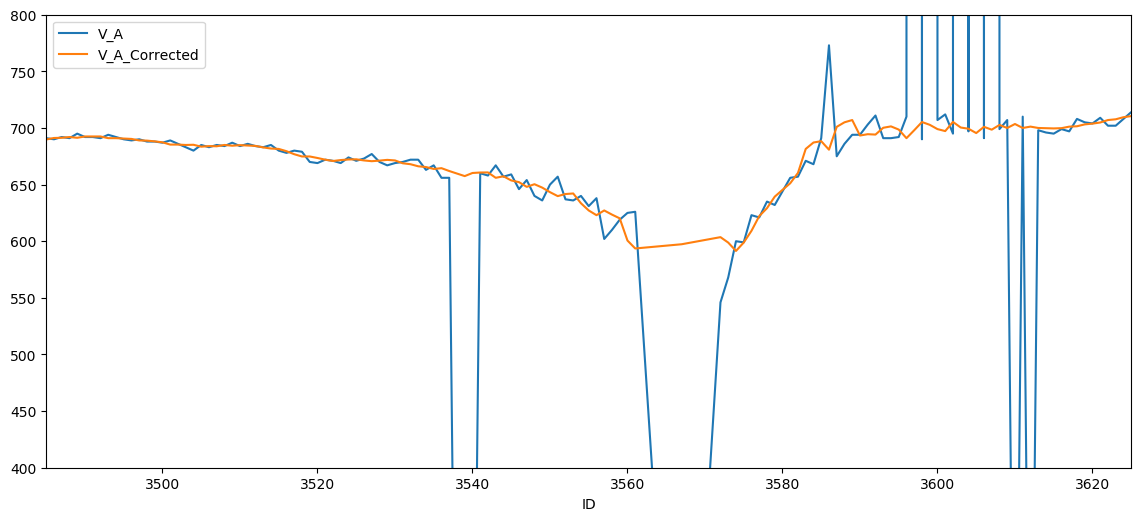

In [34]:
#问题：ABC三处电压测量值和校正值差异
#回答：可以认为相等

figure(num=None, figsize=(14, 6), dpi=100, facecolor='w', edgecolor='k')

ax = plt.gca()

# df.plot(x='ID',xlim=(3595,3605),y='V_A',ylim=(620,800),label='V_A',ax=ax)
df.plot(x='ID',xlim=(3485,3625),y='V_A',ylim=(400,800),label='V_A',ax=ax)
df.plot(x='ID',y='rolling_six_VA',label='V_A_Corrected',ax=ax)
# dfp.plot(x='ID',y='V_B',label='V_B',ax=ax)
# dfp.plot(x='ID',y='V_C',label='V_C',ax=ax)

plt.show()

In [19]:
# CORRECTION!!!
# df.loc[condition , ['P_avg_corrected']]=1/3*df['I_A']*(df['rolling_eight_VA']+df['rolling_eight_VB']+df['rolling_eight_VC'])

In [19]:
df['magic_feature'] = df['ID']%190

In [20]:
train = df[df['is_train']==1]
test = df[df['is_train']==0]

C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


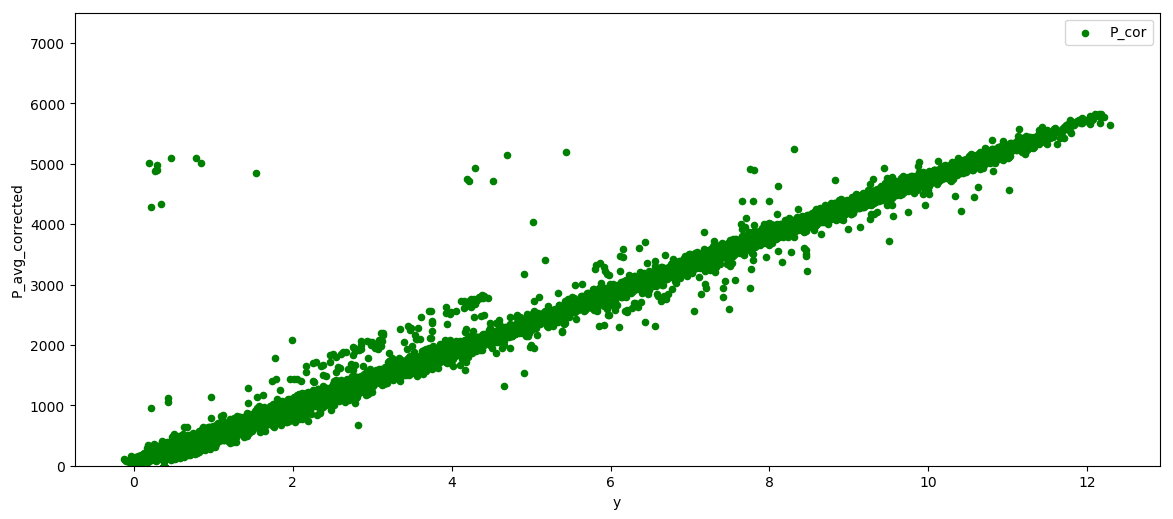

C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,ID,light_strength,board_t,I_A,V_A,V_B,V_C,y
1373,1519,9,0.25,7.04,77,65387,14,0.839478
1722,1894,30,0.24,7.10,74,65350,22,0.780917
3253,3538,36,0.21,6.56,36,37,65463,0.344703
3255,3540,36,0.33,6.50,36,65463,18,0.209395
3305,3599,60,-12.00,6.97,65419,5,64,0.268685
3309,3603,66,-11.62,7.01,65420,3,67,0.286363
3311,3605,66,-11.62,7.01,65420,11,67,0.278587
3313,3607,66,-11.62,7.09,65420,15,68,0.286621
3318,3612,69,0.72,7.13,37,65422,5,0.192079
3429,3723,91,0.12,7.21,39,42,65440,0.460215


In [45]:
# 功率测量值异常时，y和功率校正值的关系
c_df = train[df['to_correct']==1]

figure(num=None, figsize=(14, 6), dpi=100, facecolor='w', edgecolor='k')

ax = plt.gca()

# c_df.plot.scatter(x='y',y='P_avg',label='P',secondary_y=True,color='red',ax=ax)
# c_df.plot.scatter(x='y',y='P_avg_corrected',ylim=(0,7500),label='P_cor',color='green',ax=ax)

# c_df.plot.scatter(x='y',y='P_A',label='PA',secondary_y=True,color='red',ax=ax)
# c_df.plot.scatter(x='y',y='PA_corrected',ylim=(0,7500),label='PA_cor',color='green',ax=ax)

# train.plot.scatter(x='y',y='P_A',ylim=(0,7500),label='PA',secondary_y=True,color='red',ax=ax)
# train.plot.scatter(x='y',y='PA_corrected',ylim=(0,7500),label='PA_cor',color='green',ax=ax)

# train.plot.scatter(x='y',y='P_avg',ylim=(0,7500),label='P',secondary_y=True,color='red',ax=ax)
train.plot.scatter(x='y',y='P_avg_corrected',ylim=(0,7500),label='P_cor',color='green',ax=ax)

# inter_y_id.plot(x='ID',y='y',ylim=(-1,14),ax=ax)

plt.show()


high_P_low_y_df=train[(df['y']<2) & (df['P_avg_corrected']>4000)]
high_P_low_y_df[['ID','light_strength','board_t','I_A','V_A','V_B','V_C','y']]

In [21]:
#特征同时包含P_avg和P_avg_corrected（local cv 为0.8613）不如只包含P_avg_corrected
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l2',
    'metric': 'mse',
    'num_leaves': 31,
    'learning_rate': 0.08,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'verbose': 0
}
# 同样的条件下，此参数设置达到local cv: 0.8575832021441638


test_predicts = []
val_preds = []

# log_test_predicts = []
# log_val_predicts = []
for idx, seed in enumerate([1,2,3,4,5]):
    kf = KFold(5, shuffle=True, random_state=seed)
    
    val_preds.append(np.zeros(train.shape[0]))
    for n_fold, (tra_idx, val_idx) in enumerate(kf.split(train)):
        tra = train.iloc[tra_idx]
        val = train.iloc[val_idx]
        tst = test.copy()

#         grouper = ['bin_ls','bin_env_t','bin_board_t']
#         x = tra.groupby(grouper)['y'].agg({'target_encoding_mean':'mean',
#                                            'target_encoding_max':'max',
#                                            'target_encoding_min':'min',
#                                            'target_encoding_median':'median',
#                                            'target_encoding_var':'var',
#                                            'target_encoding_count':'count'}).reset_index()
#         tra = tra.merge(x, on=grouper, how='left')
#         val = val.merge(x, on= grouper , how ='left')
#         tst = tst.merge(x, on=grouper, how='left')
        predictor = [c for c in tra.columns.tolist() if c not in['y','is_train','I_B','I_C',]]
#         predictor = [c for c in tra.columns.tolist() if c in['P_A','P_B','P_C','P_avg_corrected','I_A','light_strength','board_t','avg_value','wind_direction','wind_speed','rolling_six_y']]

        train_set = lightgbm.Dataset(
            tra[predictor],
            tra['y']
        )

        validation_set = lightgbm.Dataset(
            val[predictor],
            val['y']
        )

        model = lightgbm.train(params, train_set, num_boost_round=5000,
                              valid_sets= [validation_set],
                              valid_names=['valid'],
                              early_stopping_rounds=100,
                               feval=my_val,
                              verbose_eval=500)

        val_preds[idx][val_idx] = model.predict(val[predictor])
        test_predicts.append(model.predict(tst[predictor]))

print('local cv:',1/(1+np.sqrt(mean_squared_error(train['y'],np.mean(val_preds,axis=0)))))


Training until validation scores don't improve for 100 rounds.
[500]	valid's l2: 0.0578238	valid's score: 0.806149
Early stopping, best iteration is:
[593]	valid's l2: 0.0577237	valid's score: 0.806284
Training until validation scores don't improve for 100 rounds.
[500]	valid's l2: 0.0178938	valid's score: 0.882015
[1000]	valid's l2: 0.0172101	valid's score: 0.884027
Early stopping, best iteration is:
[1011]	valid's l2: 0.0171905	valid's score: 0.884085
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[155]	valid's l2: 0.0122378	valid's score: 0.900394
Training until validation scores don't improve for 100 rounds.
[500]	valid's l2: 0.0360689	valid's score: 0.840394
[1000]	valid's l2: 0.0339241	valid's score: 0.844463
Early stopping, best iteration is:
[1295]	valid's l2: 0.0335559	valid's score: 0.845178
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[249]	valid's l2: 0.0152471	valid's sc

In [22]:
pd.Series(model.feature_importance(importance_type='gain'),
          index=model.feature_name()).sort_values(ascending=False)

P_A                  239939.648149
P_avg_corrected       96993.393061
PA_corrected          50429.571960
avg_value             25906.924573
P_C                   13761.742020
I_A                    8011.689129
P_avg                  5706.877067
rolling_six_y          3646.770236
P_B                    2882.970777
prev_value             1392.157844
V_B_filtered            405.524150
next_value              168.904392
light_strength          153.103700
efficiency              113.641015
wind_direction          102.432109
V_C_filtered             97.920698
second_prev_value        95.382924
rolling_six_VB           75.648911
board_t                  75.271153
wind_speed               58.865745
efficiency_C             50.554779
V_A                      39.354636
to_correct               37.492387
V_B                      35.315550
efficiency_B             35.209665
efficiency_A             26.786931
ID                       26.726236
env_t                    20.236663
V_A_filtered        

In [25]:
xx = train[['y','ID']]
xx['val'] = np.mean(val_preds, axis=0)
print('local cv:',1/(1+np.sqrt(mean_squared_error(xx['y'],xx['val']))))

local cv: 0.862062412622716


C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [45]:
yy = xx.drop(xx[xx['ID'].isin([3152,15355])].index)
print('local cv:',1/(1+np.sqrt(mean_squared_error(yy['y'],yy['val']))))

local cv: 0.8885432677212384


In [25]:
train['diff'] = train['y']-np.mean(val_preds,axis=0)

C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [24]:
train['diff'].describe()

count    9000.000000
mean        0.000247
std         0.158656
min        -8.563042
25%        -0.034902
50%        -0.000187
75%         0.032941
max         3.408204
Name: diff, dtype: float64

In [32]:
train[train['diff']>train['diff'].quantile(0.99)].sort_values(by=['diff'],ascending = False, inplace = False)[['ID','I_A','V_A','V_B','V_C','P_avg','P_avg_corrected','y','diff']]


,ID,I_A,V_A,V_B,V_C,P_avg,P_avg_corrected,y,diff
2890,3152,6.67,3,33,260,330.98,4384.413333,7.650842,4.884751
11366,11832,7.90,622,618,146,3687.53,4887.027778,10.814965,1.966502
16367,16833,6.19,652,639,645,4225.40,4225.400000,10.409262,1.744529
16596,17062,2.11,618,619,641,1321.81,1321.810000,4.659551,1.716919
14850,15316,4.22,674,673,672,2790.74,2790.740000,7.420245,1.711897
16574,17040,2.19,646,636,633,3923.32,3923.320000,7.661126,1.707223
9780,10244,5.74,658,666,657,3718.52,3718.520000,9.510625,1.649472
8556,9020,3.69,675,676,676,2560.81,2560.810000,7.044717,1.607562
13080,13546,2.60,601,604,607,2565.64,2565.640000,6.185506,1.501035
8534,8998,6.95,657,655,655,4563.43,4563.430000,11.018298,1.432997


In [49]:
train[(train['ID']<15355+30) & (train['ID']>15355-30)][['ID','board_t','env_t','light_strength','I_A','V_A','V_B','V_C','P_avg','P_avg_corrected','y','diff']]

,ID,board_t,env_t,light_strength,I_A,V_A,V_B,V_C,P_avg,P_avg_corrected,y,diff
14861,15327,8.68,2.9,556,5.15,667,665,663,3473.47,3473.47,7.082491,0.063506
14862,15328,8.72,3.0,564,5.24,667,663,665,3528.85,3528.85,7.183631,0.057996
14863,15329,8.91,2.6,572,5.34,666,661,663,3612.81,3612.81,7.349603,0.081750
14864,15330,8.91,2.6,572,5.34,666,661,663,3612.81,3612.81,7.349603,0.190510
14866,15332,9.45,2.6,595,5.79,664,660,660,3829.12,3829.12,7.826322,0.299832
14867,15333,9.70,3.0,601,5.93,661,660,659,3878.61,3878.61,7.978552,0.095582
14868,15334,10.83,3.3,615,6.12,659,656,655,3994.77,3994.77,8.227259,0.371746
14869,15335,10.43,3.1,624,6.14,660,656,655,4031.79,4031.79,5.017695,-3.289499
14873,15339,11.20,3.8,644,6.51,656,654,653,4283.65,4283.65,8.764451,-0.047850
14875,15341,11.91,4.1,656,6.64,657,651,650,4368.38,4368.38,8.993718,0.218193


In [33]:
train[train['diff']<train['diff'].quantile(0.01)].sort_values(by=['diff'],ascending = True, inplace = False)[['ID','board_t','env_t','light_strength','I_A','V_A','V_B','V_C','P_avg','P_avg_corrected','y','diff']]


,ID,board_t,env_t,light_strength,I_A,V_A,V_B,V_C,P_avg,P_avg_corrected,y,diff
14889,15355,15.78,4.4,717,7.50,641,635,642,4842.01,4842.010000,1.541522,-8.518770
14869,15335,10.43,3.1,624,6.14,660,656,655,4031.79,4031.790000,5.017695,-3.311785
8043,8505,-6.99,-12.1,198,2.92,714,713,714,2081.55,2081.550000,1.984719,-2.353387
13275,13741,26.83,23.3,549,4.93,628,623,617,3406.48,3406.480000,5.179986,-1.800906
15592,16058,15.72,9.0,846,7.30,650,640,635,5236.70,5236.700000,8.304743,-1.774915
5167,5605,7.60,-3.5,527,6.71,667,662,658,4624.62,4624.620000,8.113857,-1.466912
10818,11284,8.97,1.1,504,5.48,666,662,662,3610.79,3610.790000,6.352940,-1.232680
3313,3607,-11.62,-11.5,66,7.09,65420,15,68,157829.65,4974.816667,0.286621,-1.175022
6818,7278,4.47,-4.6,295,2.63,672,677,683,1915.27,1915.270000,2.832847,-1.164301
14995,15461,19.79,5.9,587,5.49,632,630,630,3456.06,3456.060000,6.158969,-1.153730


In [31]:
train['corrected_diff']=np.abs(train['P_avg_corrected']-train['P_avg'])
# train[train['corrected_diff']>train['corrected_diff'].quantile(0.5)].sort_values(by=['corrected_diff'],ascending = False, inplace = False)[['ID','light_strength','I_A','V_A','V_B','V_C','P_avg','P_avg_corrected','y','diff','VA_corrected','VB_corrected','VC_corrected']]
train.sort_values(by=['corrected_diff'],ascending = False, inplace = False)[['ID','light_strength','I_A','V_A','V_B','V_C','P_avg','P_avg_corrected','y','diff','VA_corrected','VB_corrected','VC_corrected']]

C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,ID,light_strength,I_A,V_A,V_B,V_C,P_avg,P_avg_corrected,y,diff,VA_corrected,VB_corrected,VC_corrected
1722,1894,30,7.10,74,65350,22,160151.37,5098.983333,0.780917,-0.699030,724.833333,711.333333,718.333333
1065,1173,233,7.04,65408,22,250,158484.77,4909.617778,7.753474,-0.079364,681.666667,703.750000,706.750000
14,22,100,7.19,65382,7,107,158302.85,5188.383889,5.440741,1.269022,722.666667,721.333333,720.833333
1178,1286,100,7.18,310,307,65438,158089.59,5139.284444,4.694385,0.009470,716.000000,716.666667,714.666667
1373,1519,9,7.04,77,65387,14,157912.11,5005.440000,0.839478,-0.069905,712.000000,712.833333,708.166667
1237,1362,233,7.00,65386,23,244,157793.07,4901.166667,7.806384,0.151863,702.000000,699.333333,699.166667
3313,3607,66,7.09,65420,15,68,157829.65,4974.816667,0.286621,-1.218317,698.500000,702.500000,704.000000
3311,3605,66,7.01,65420,11,67,155300.48,4899.990000,0.278587,-0.624594,695.500000,703.000000,698.500000
3318,3612,69,7.13,37,65422,5,154903.24,5011.082833,0.192079,-0.294091,701.200000,707.500000,699.750000
3429,3723,91,7.21,39,42,65440,154630.97,5093.063889,0.460215,-0.667082,717.833333,698.666667,702.666667


In [21]:
pd.Series(model.feature_importance(importance_type='gain'),
          index=model.feature_name()).sort_values(ascending=False)

P_A                  219849.921970
P_avg_corrected      151836.910854
P_C                   26880.588469
next_value            13476.243533
I_A                   13064.048228
avg_value             11612.234950
P_B                    5271.531258
rolling_eight_y        3594.696172
prev_value             3356.683905
light_strength          482.740767
V_A                     198.036788
second_prev_value       159.444075
efficiency              141.554383
efficiency_C            129.109484
wind_direction          106.442340
efficiency_B             88.436741
V_C                      86.575378
wind_speed               79.913607
efficiency_A             62.625825
board_t                  61.072833
env_t                    56.222156
V_B                      50.966678
ID                       48.244384
second_next_value        44.463844
magic_feature            37.035770
next_ID                  15.433272
prev_ID                   3.947307
dtype: float64

In [20]:
test['ans'] = np.mean(test_predicts, axis=0)

C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [21]:
for index, row in test.iterrows():
    if row['I_A'] == 0:
        test.at[index,'ans'] = 0.379993 
        print("Hi!"+str(index))

test[test['I_A']==0][['ID','I_A','V_A','V_B','V_C','ans']]

Hi!0
Hi!855
Hi!1543
Hi!1714
Hi!2583
Hi!2930
Hi!4123
Hi!4300
Hi!4462
Hi!4632
Hi!4633
Hi!4674
Hi!4675
Hi!4867
Hi!4870
Hi!5072
Hi!5463
Hi!5665
Hi!6071
Hi!6074
Hi!7684
Hi!7783
Hi!7848
Hi!8026
Hi!8624
Hi!8832
Hi!9041
Hi!9255
Hi!9452
Hi!9660
Hi!9871
Hi!10272
Hi!10453
Hi!10653
Hi!11497
Hi!13364
Hi!13566
Hi!13777
Hi!13991
Hi!14833
Hi!15042
Hi!15678
Hi!15882
Hi!16459
Hi!16876
Hi!17061


,ID,I_A,V_A,V_B,V_C,ans
0,1,0.0,0,0,0,0.379993
855,940,0.0,0,0,0,0.379993
1543,1694,0.0,0,0,0,0.379993
1714,1879,0.0,0,0,0,0.379993
2583,2823,0.0,0,0,0,0.379993
2930,3202,0.0,0,0,0,0.379993
4123,4459,0.0,0,0,0,0.379993
4300,4648,0.0,0,0,0,0.379993
4462,4821,0.0,0,0,0,0.379993
4632,5010,0.0,0,0,0,0.379993


In [22]:
test[['ID','ans']].to_csv('../result/080703_086012.csv',header=False, index=False)